<a href="https://colab.research.google.com/github/curoled345/Automoblie-Project/blob/main/0707.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### 1. 필요한 라이브러리 설치 및 임포트

In [3]:
!pip install opencv-python matplotlib pillow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image

- opencv-python : OpenCV 라이브러리로 컴퓨터 비전 작업을 수행

- numpy : 이미지 데이터를 배열로 다루기 위해 사용

- matplotlib : 분석 결과를 시각화할 때 사용

- pillow (PIL) : 이미지 파일을 처리하고 열기 위한 라이브러리

- google.colab.files : 구글 콜랩에서 파일을 업로드하는 기능 제공

- io : 파일 데이터를 메모리에서 읽을 수 있게 함

### 2. 한글 폰트 설정

In [ ]:
import matplotlib.font_manager as fm

# Colab에서 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

- NanumBarunGothic 폰트를 설치하여 한글이 잘 표시되도록 설정

### 3. OpenCVTrafficSignRecognizer 클래스 정의

   OpenCVTrafficSignRecognizer 클래스는 교통표지판 인식을 담당하는 주요 클래스로, 색상, 모양, 텍스트 패턴을 기반으로 교통표지판을 인식합니다.

초기화 및 색상 범위 정의

In [4]:
class OpenCVTrafficSignRecognizer:
    def __init__(self):
        self.color_ranges = {
            'red': {...},  # 빨간색 범위
            'blue': {...},  # 파란색 범위
            'yellow': {...},  # 노란색 범위
            'green': {...}  # 초록색 범위
        }

- 색상 범위 정의 : 각 색상별 HSV (색상, 채도, 명도) 범위를 설정하여 교통표지판 색상 검출을 용이하게 합니다.

색상 기반 표지판 분류 (detect_color)

In [5]:
def detect_color(self, image):
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    detected_colors = []
    for color_name, color_info in self.color_ranges.items():
        if color_name == 'red':
            # 빨간색은 HSV에서 두 범위로 나뉨
            mask1 = cv2.inRange(hsv, color_info['lower1'], color_info['upper1'])
            mask2 = cv2.inRange(hsv, color_info['lower2'], color_info['upper2'])
            mask = cv2.bitwise_or(mask1, mask2)
        else:
            mask = cv2.inRange(hsv, color_info['lower'], color_info['upper'])

        color_pixels = cv2.countNonZero(mask)
        total_pixels = image.shape[0] * image.shape[1]
        color_ratio = color_pixels / total_pixels
        if color_ratio > 0.1:
            detected_colors.append({'color': color_name, 'ratio': color_ratio, 'sign_type': color_info['sign_type'], 'mask': mask})

    if detected_colors:
        return max(detected_colors, key=lambda x: x['ratio'])
    return None

- HSV 색공간 변환 : 이미지를 HSV 색공간으로 변환하여 색상을 추출합니다.

- 색상 검출 : 각 색상별로 마스크를 만들어 색상이 포함된 영역을 검출하고, 색상 비율이 10% 이상인 경우 해당 색상으로 판단합니다.

모양 기반 표지판 분류 (detect_shapes)

In [ ]:
def detect_shapes(self, image):
    gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    edges = cv2.Canny(blurred, 50, 150)
    contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    shapes = []

    for contour in contours:
        if cv2.contourArea(contour) < 500:
            continue
        epsilon = 0.02 * cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, epsilon, True)
        vertices = len(approx)
        if vertices == 3:
            shape_type = "triangle_warning_sign"
        elif vertices == 4:
            x, y, w, h = cv2.boundingRect(approx)
            aspect_ratio = w / float(h)
            if 0.95 <= aspect_ratio <= 1.05:
                shape_type = "square_general_sign"
            else:
                shape_type = "rectangle_guide_sign"
        elif 5 <= vertices <= 10:
            shape_type = "octagon_stop_sign"
        else:
            area = cv2.contourArea(contour)
            perimeter = cv2.arcLength(contour, True)
            if perimeter > 0:
                circularity = 4 * np.pi * area / (perimeter * perimeter)
                if circularity > 0.7:
                    shape_type = "circle_direction_sign"
                else:
                    shape_type = "other_shape"
            else:
                shape_type = "other_shape"
        shapes.append({'shape': shape_type, 'vertices': vertices, 'area': cv2.contourArea(contour), 'contour': contour})

    if shapes:
        return max(shapes, key=lambda x: x['area'])
    return None

- 모양 검출 : 이미지를 그레이스케일로 변환하고, 블러와 에지 검출을 통해 교통표지판의 모양을 추출합니다. 각 모양을 기준으로 교통표지판을 구분합니다.

텍스트 패턴 인식 (detect_text_patterns)

In [6]:
def classify_traffic_sign(self, image):
    color_result = self.detect_color(image)
    shape_result = self.detect_shapes(image)
    text_result = self.detect_text_patterns(image)

    classification = {'color_info': color_result, 'shape_info': shape_result, 'text_info': text_result, 'final_prediction': 'unknown_sign'}

    if color_result and shape_result:
        color = color_result['color']
        shape = shape_result['shape']
        if color == 'red':
            if 'octagon' in shape or 'text_included' in str(text_result):
                classification['final_prediction'] = 'stop_sign'
            else:
                classification['final_prediction'] = 'prohibition_sign'
        elif color == 'blue':
            if 'circle' in shape:
                classification['final_prediction'] = 'direction_sign'
            else:
                classification['final_prediction'] = 'guide_sign'
        elif color == 'yellow':
            if 'triangle' in shape:
                classification['final_prediction'] = 'warning_sign'
            else:
                classification['final_prediction'] = 'caution_sign'
        elif color == 'green':
            classification['final_prediction'] = 'safety_sign'

    return classification

- 텍스트 인식 : 이미지의 중앙 부분에서 흰색 픽셀의 비율을 계산하여, "STOP" 텍스트 패턴이 포함된 가능성을 판단합니다.



교통표지판 분류 (classify_traffic_sign)

In [ ]:
def classify_traffic_sign(self, image):
    color_result = self.detect_color(image)
    shape_result = self.detect_shapes(image)
    text_result = self.detect_text_patterns(image)

    classification = {'color_info': color_result, 'shape_info': shape_result, 'text_info': text_result, 'final_prediction': 'unknown_sign'}

    if color_result and shape_result:
        color = color_result['color']
        shape = shape_result['shape']
        if color == 'red':
            if 'octagon' in shape or 'text_included' in str(text_result):
                classification['final_prediction'] = 'stop_sign'
            else:
                classification['final_prediction'] = 'prohibition_sign'
        elif color == 'blue':
            if 'circle' in shape:
                classification['final_prediction'] = 'direction_sign'
            else:
                classification['final_prediction'] = 'guide_sign'
        elif color == 'yellow':
            if 'triangle' in shape:
                classification['final_prediction'] = 'warning_sign'
            else:
                classification['final_prediction'] = 'caution_sign'
        elif color == 'green':
            classification['final_prediction'] = 'safety_sign'

    return classification

- 종합적인 교통표지판 분류 : 색상, 모양, 텍스트 패턴을 종합적으로 분석하여 교통표지판을 분류합니다.

###4. 이미지 업로드 및 분석 (upload_and_analyze)

In [ ]:
def upload_and_analyze(self):
    uploaded = files.upload()
    for filename, file_data in uploaded.items():
        image = Image.open(io.BytesIO(file_data))
        image_array = np.array(image)
        result = self.classify_traffic_sign(image_array)
        self.visualize_detection(image_array, result)


- 파일 업로드 : 구글 콜랩에서 이미지를 업로드하고, 업로드된 이미지를 분석하여 결과를 출력합니다.

### 5. 시각화 (visualize_detection)
- 이미지 및 분석 결과 시각화: 이미지, HSV 변환, 색상 마스크, 에지 검출, 모양 검출 결과 등을 시각화하여 인식된 교통표지판의 특징을 확인할 수 있도록 합니다.

### 6. 주요 실행 흐름 (main)

In [7]:
def main():
    recognizer = OpenCVTrafficSignRecognizer()
    while True:
        recognizer.upload_and_analyze()
        continue_choice = input("🔄 다른 이미지도 분석하시겠어요? (y/n): ")
        if continue_choice.lower() != 'y':
            break

###Final. 총 정리!

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 35 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 1s (11.4 MB/s)
Selecting previously unselected package fonts-nanum.
(Reading database ... 126308 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20200506-1_all.deb ...
Unpacking fonts-nanum (20200506-1) ...
Setting up fonts-nanum (20200506-1) ...
Processing triggers for fontconfig (2.13.1-4.2ubuntu5) ...
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 3 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/

Saving KakaoTalk_20250707_110916264.jpg to KakaoTalk_20250707_110916264.jpg

🔍 'KakaoTalk_20250707_110916264.jpg' 분석 중...

🎯 분석 결과: unknown_sign
📐 검출된 모양: rectangle_guide_sign
📝 텍스트 정보: ['text_included_stop_possible']
🔍 Debug: 'unknown_sign' → 'Unknown Sign'


/tmp/ipython-input-1-4271080312.py:308: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


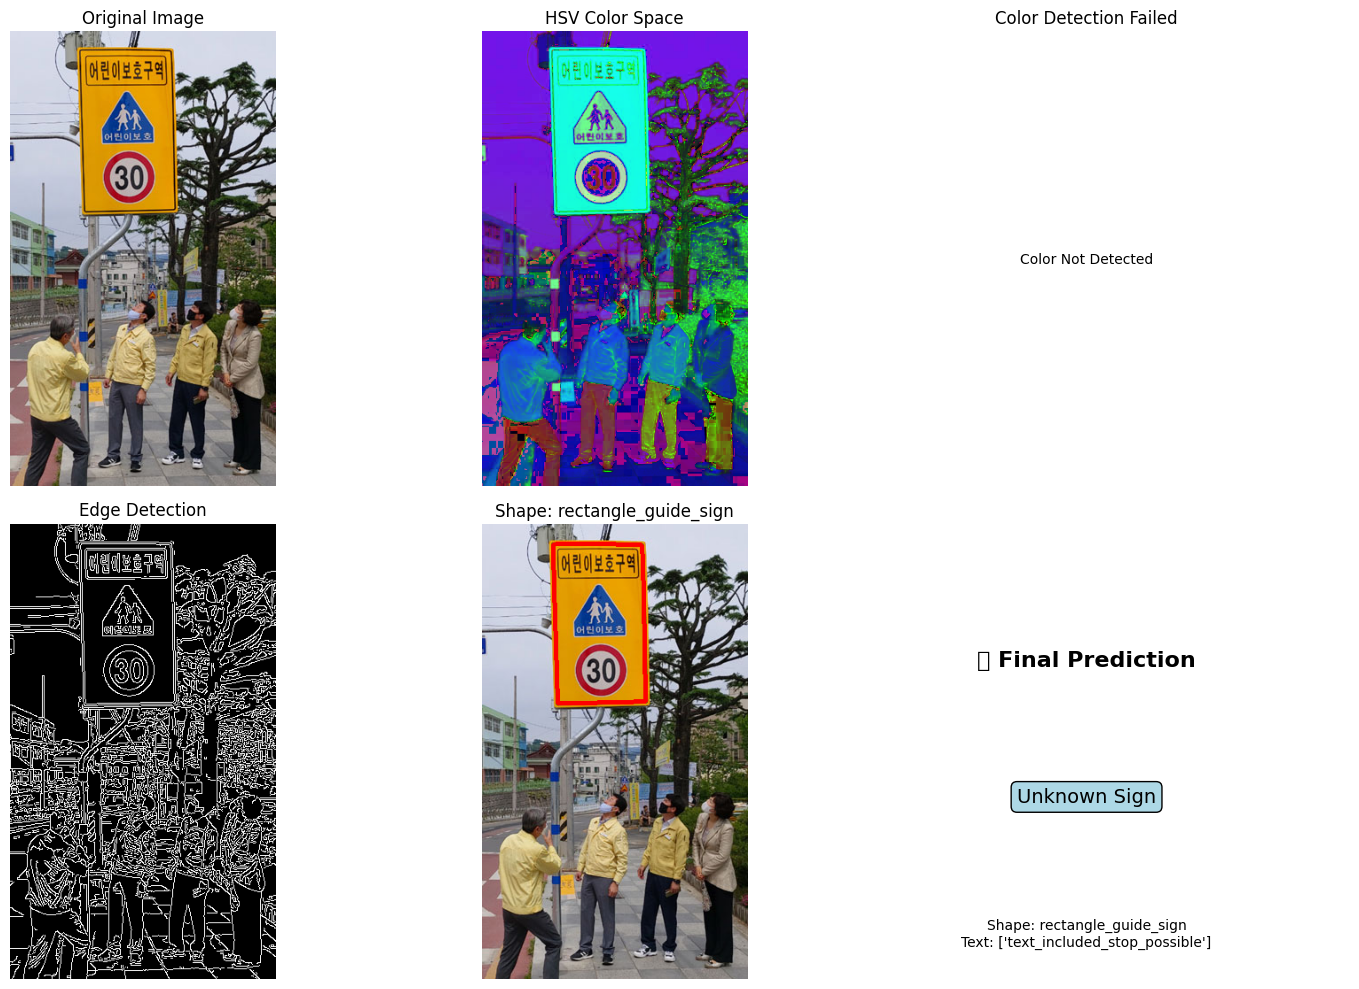

--------------------------------------------------

🔄 다른 이미지도 분석하시겠어요? (y/n): ㅜ

🎉 OpenCV 교통표지판 인식 완료!


In [1]:
!pip install opencv-python matplotlib pillow
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import io
from PIL import Image

# 한글 폰트 설정 (Colab용)
import matplotlib.font_manager as fm

# Colab에서 한글 폰트 설치
!apt-get install -y fonts-nanum
!fc-cache -fv
!rm ~/.cache/matplotlib -rf

# 한글 폰트 설정
plt.rcParams['font.family'] = 'NanumBarunGothic'
plt.rcParams['axes.unicode_minus'] = False

class OpenCVTrafficSignRecognizer:
    def __init__(self):
        # 색상 범위 정의 (HSV 색공간)
        self.color_ranges = {
            'red': {
                'lower1': np.array([0, 120, 70]),    # 빨간색 범위1
                'upper1': np.array([10, 255, 255]),
                'lower2': np.array([170, 120, 70]),  # 빨간색 범위2
                'upper2': np.array([180, 255, 255]),
                'sign_type': 'stop_prohibition'
            },
            'blue': {
                'lower': np.array([90, 100, 50]),    # 파란색
                'upper': np.array([150, 255, 255]),
                'sign_type': 'direction_guide'
            },
            'yellow': {
                'lower': np.array([15, 150, 150]),   # 노란색
                'upper': np.array([35, 255, 255]),
                'sign_type': 'warning_caution'
            },
            'green': {
                'lower': np.array([40, 150, 100]),   # 초록색
                'upper': np.array([80, 255, 255]),
                'sign_type': 'safety_permission'
            }
        }

    def detect_color(self, image):
        """색상 기반 표지판 분류"""
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

        detected_colors = []

        for color_name, color_info in self.color_ranges.items():
            if color_name == 'red':
                # 빨간색은 HSV에서 두 범위로 나뉨
                mask1 = cv2.inRange(hsv, color_info['lower1'], color_info['upper1'])
                mask2 = cv2.inRange(hsv, color_info['lower2'], color_info['upper2'])
                mask = cv2.bitwise_or(mask1, mask2)
            else:
                mask = cv2.inRange(hsv, color_info['lower'], color_info['upper'])

            # 색상 픽셀 수 계산
            color_pixels = cv2.countNonZero(mask)
            total_pixels = image.shape[0] * image.shape[1]
            color_ratio = color_pixels / total_pixels

            if color_ratio > 0.1:  # 10% 이상이면 해당 색상으로 판정
                detected_colors.append({
                    'color': color_name,
                    'ratio': color_ratio,
                    'sign_type': color_info['sign_type'],
                    'mask': mask
                })

        # 가장 많은 색상 반환
        if detected_colors:
            return max(detected_colors, key=lambda x: x['ratio'])
        return None

    def detect_shapes(self, image):
        """모양 기반 표지판 분류"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # 가우시안 블러 적용
        blurred = cv2.GaussianBlur(gray, (5, 5), 0)

        # 에지 검출
        edges = cv2.Canny(blurred, 50, 150)

        # 컨투어 찾기
        contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        shapes = []

        for contour in contours:
            # 작은 컨투어 무시
            if cv2.contourArea(contour) < 500:
                continue

            # 컨투어 근사화
            epsilon = 0.02 * cv2.arcLength(contour, True)
            approx = cv2.approxPolyDP(contour, epsilon, True)

            # 꼭짓점 수로 모양 판별
            vertices = len(approx)

            # 모양 분류
            if vertices == 3:
                shape_type = "triangle_warning_sign"
            elif vertices == 4:
                # 사각형인지 확인
                x, y, w, h = cv2.boundingRect(approx)
                aspect_ratio = w / float(h)
                if 0.95 <= aspect_ratio <= 1.05:
                    shape_type = "square_general_sign"
                else:
                    shape_type = "rectangle_guide_sign"
            elif 5 <= vertices <= 10:
                shape_type = "octagon_stop_sign"
            else:
                # 원형 여부 확인
                area = cv2.contourArea(contour)
                perimeter = cv2.arcLength(contour, True)
                if perimeter > 0:
                    circularity = 4 * np.pi * area / (perimeter * perimeter)
                    if circularity > 0.7:
                        shape_type = "circle_direction_sign"
                    else:
                        shape_type = "other_shape"
                else:
                    shape_type = "other_shape"

            shapes.append({
                'shape': shape_type,
                'vertices': vertices,
                'area': cv2.contourArea(contour),
                'contour': contour
            })

        # 가장 큰 모양 반환
        if shapes:
            return max(shapes, key=lambda x: x['area'])
        return None

    def detect_text_patterns(self, image):
        """텍스트 패턴 인식 (간단한 템플릿 매칭)"""
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # 이진화
        _, binary = cv2.threshold(gray, 128, 255, cv2.THRESH_BINARY)

        # STOP 텍스트 특징 검사 (간단한 방법)
        # 중앙 영역의 백색 픽셀 패턴 확인
        h, w = binary.shape
        center_region = binary[h//3:2*h//3, w//4:3*w//4]
        white_pixels = cv2.countNonZero(center_region)
        total_pixels = center_region.shape[0] * center_region.shape[1]

        text_patterns = []

        if white_pixels / total_pixels > 0.3:  # 30% 이상 흰 픽셀
            text_patterns.append("text_included_stop_possible")

        return text_patterns

    def classify_traffic_sign(self, image):
        """종합적인 교통표지판 분류"""
        # 1. 색상 검출
        color_result = self.detect_color(image)
        # 2. 모양 검출
        shape_result = self.detect_shapes(image)
        # 3. 텍스트 패턴 검출
        text_result = self.detect_text_patterns(image)
        # 4. 종합 판단
        classification = {
            'color_info': color_result,
            'shape_info': shape_result,
            'text_info': text_result,
            'final_prediction': 'unknown_sign'
        }

        # 규칙 기반 분류
        if color_result and shape_result:
            color = color_result['color']
            shape = shape_result['shape']

            if color == 'red':
                if 'octagon' in shape or 'text_included' in str(text_result):
                    classification['final_prediction'] = 'stop_sign'
                else:
                    classification['final_prediction'] = 'prohibition_sign'
            elif color == 'blue':
                if 'circle' in shape:
                    classification['final_prediction'] = 'direction_sign'
                else:
                    classification['final_prediction'] = 'guide_sign'
            elif color == 'yellow':
                if 'triangle' in shape:
                    classification['final_prediction'] = 'warning_sign'
                else:
                    classification['final_prediction'] = 'caution_sign'
            elif color == 'green':
                classification['final_prediction'] = 'safety_sign'

        elif color_result:
            # 색상만으로 판단
            if color_result['sign_type'] == 'stop_prohibition':
                classification['final_prediction'] = 'stop_sign'
            elif color_result['sign_type'] == 'direction_guide':
                classification['final_prediction'] = 'direction_sign'
            elif color_result['sign_type'] == 'warning_caution':
                classification['final_prediction'] = 'warning_sign'
            elif color_result['sign_type'] == 'safety_permission':
                classification['final_prediction'] = 'safety_sign'
            else:
                classification['final_prediction'] = color_result['sign_type']

        elif shape_result:
            # 모양만으로 판단
            if 'octagon' in shape_result['shape']:
                classification['final_prediction'] = 'stop_sign_by_shape'
            elif 'triangle' in shape_result['shape']:
                classification['final_prediction'] = 'warning_sign_by_shape'
            elif 'circle' in shape_result['shape']:
                classification['final_prediction'] = 'direction_sign_by_shape'

        return classification

    def visualize_detection(self, image, classification):
        """검출 결과 시각화"""
        plt.figure(figsize=(15, 10))

        # 1. 원본 이미지
        plt.subplot(2, 3, 1)
        plt.imshow(image)
        plt.title('Original Image')
        plt.axis('off')

        # 2. HSV 이미지
        hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        plt.subplot(2, 3, 2)
        plt.imshow(hsv)
        plt.title('HSV Color Space')
        plt.axis('off')

        # 3. 색상 마스크
        plt.subplot(2, 3, 3)
        if classification['color_info']:
            plt.imshow(classification['color_info']['mask'], cmap='gray')
            plt.title(f"Color Detection: {classification['color_info']['color']}")
        else:
            plt.text(0.5, 0.5, 'Color Not Detected', ha='center', va='center', transform=plt.gca().transAxes)
            plt.title('Color Detection Failed')
        plt.axis('off')

        # 4. 에지 검출
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        edges = cv2.Canny(gray, 50, 150)
        plt.subplot(2, 3, 4)
        plt.imshow(edges, cmap='gray')
        plt.title('Edge Detection')
        plt.axis('off')

        # 5. 모양 검출
        plt.subplot(2, 3, 5)
        shape_image = image.copy()
        if classification['shape_info']:
            cv2.drawContours(shape_image, [classification['shape_info']['contour']], -1, (255, 0, 0), 3)
            plt.imshow(shape_image)
            plt.title(f"Shape: {classification['shape_info']['shape']}")
        else:
            plt.imshow(image)
            plt.title('Shape Not Detected')
        plt.axis('off')

        # 6. 최종 결과
        plt.subplot(2, 3, 6)
        plt.text(0.5, 0.7, '🎯 Final Prediction', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=16, fontweight='bold')

        # 영어 예측 결과를 읽기 쉬운 영어로 변환해서 표시
        prediction_english = self.convert_prediction_to_english(classification['final_prediction'])
        plt.text(0.5, 0.4, prediction_english, ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14,
                bbox=dict(boxstyle="round,pad=0.3", facecolor="lightblue"))

        # 상세 정보 (영어로)
        details = ""
        if classification['color_info']:
            details += f"Color: {classification['color_info']['color']}\n"
        if classification['shape_info']:
            details += f"Shape: {classification['shape_info']['shape']}\n"
        if classification['text_info']:
            details += f"Text: {classification['text_info']}"

        plt.text(0.5, 0.1, details, ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=10)
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    def convert_prediction_to_english(self, prediction):
        """영어 예측 결과를 더 읽기 쉬운 영어로 변환"""
        conversion_dict = {
            'stop_sign': 'STOP Sign',
            'direction_sign': 'Direction Sign',
            'warning_sign': 'Warning Sign',
            'caution_sign': 'Caution Sign',
            'safety_sign': 'Safety Sign',
            'prohibition_sign': 'Prohibition Sign',
            'guide_sign': 'Guide Sign',
            'stop_sign_by_shape': 'STOP Sign (by shape)',
            'warning_sign_by_shape': 'Warning Sign (by shape)',
            'direction_sign_by_shape': 'Direction Sign (by shape)',
            'unknown_sign': 'Unknown Sign',
            'stop_prohibition': 'STOP/Prohibition Sign',
            'direction_guide': 'Direction/Guide Sign',
            'warning_caution': 'Warning/Caution Sign',
            'safety_permission': 'Safety/Permission Sign'
        }

        result = conversion_dict.get(prediction, f'Unclassified: {prediction}')
        print(f"🔍 Debug: '{prediction}' → '{result}'")
        return result

    def upload_and_analyze(self):
        """이미지 업로드 및 분석"""
        print("📷 교통표지판 이미지를 업로드해주세요!")
        print("=" * 50)

        uploaded = files.upload()

        if not uploaded:
            print("❌ 업로드된 파일이 없습니다.")
            return

        for filename, file_data in uploaded.items():
            print(f"\n🔍 '{filename}' 분석 중...")

            try:
                # 이미지 로드
                image = Image.open(io.BytesIO(file_data))
                if image.mode != 'RGB':
                    image = image.convert('RGB')

                image_array = np.array(image)

                # 분석 수행
                result = self.classify_traffic_sign(image_array)

                # 결과 출력
                print(f"\n🎯 분석 결과: {result['final_prediction']}")
                if result['color_info']:
                    print(f"🎨 검출된 색상: {result['color_info']['color']} ({result['color_info']['ratio']:.1%})")
                if result['shape_info']:
                    print(f"📐 검출된 모양: {result['shape_info']['shape']}")
                if result['text_info']:
                    print(f"📝 텍스트 정보: {result['text_info']}")

                # 시각화
                self.visualize_detection(image_array, result)
                print("-" * 50)

            except Exception as e:
                print(f" 오류 발생: {e}")

def main():
    """메인 실행 함수"""
    print("🚗 OpenCV 교통표지판 인식 시스템")
    print("=" * 50)
    print("🎯 특징: 훈련 불필요, 즉시 인식!")
    print("🔍 방법: 색상 + 모양 + 텍스트 패턴 분석")
    print("📊 인식 가능: 정지, 지시, 경고, 안내 표지판")
    print("=" * 50)

    # 시스템 초기화
    recognizer = OpenCVTrafficSignRecognizer()

    # 이미지 분석
    while True:
        recognizer.upload_and_analyze()

        continue_choice = input("\n🔄 다른 이미지도 분석하시겠어요? (y/n): ")
        if continue_choice.lower() != 'y':
            break

    print("\n🎉 OpenCV 교통표지판 인식 완료!")

if __name__ == "__main__":
    main()

테스트 5 : 이미지 업로드 및 **처리**


📁 테스트 5: 이미지 업로드 및 처리
이미지 파일을 업로드하세요...


Saving KakaoTalk_20250707_110916264.jpg to KakaoTalk_20250707_110916264 (1).jpg


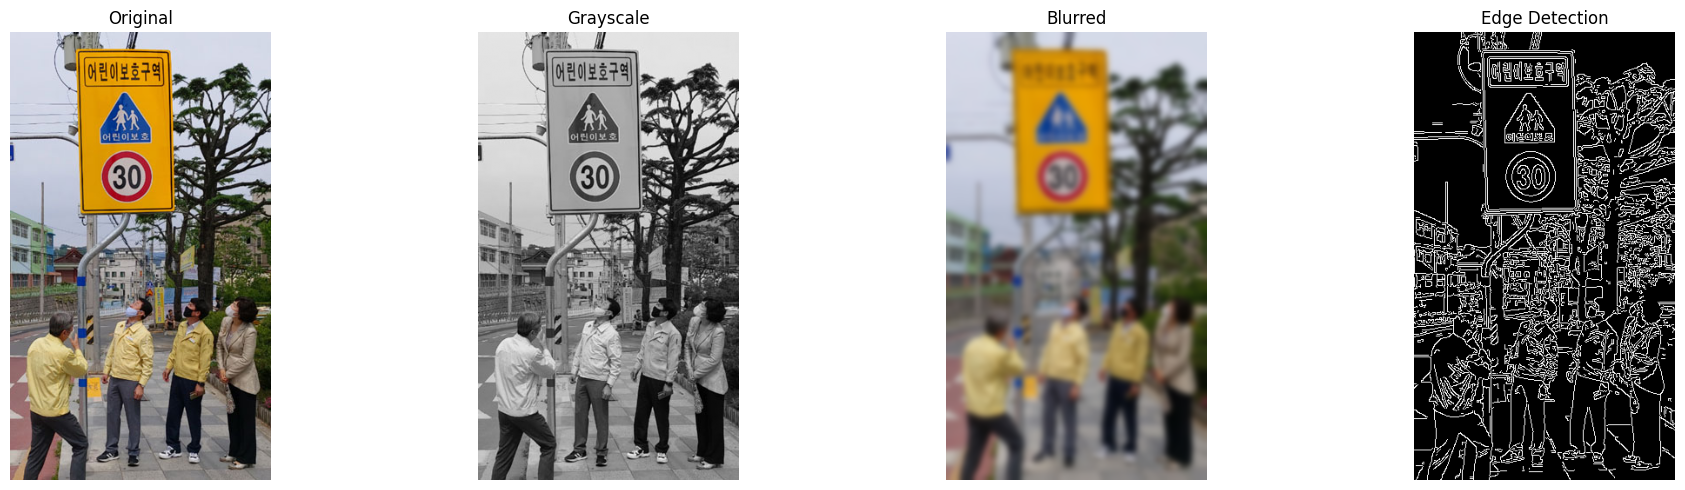

✅ 이미지 처리 완료! 크기: (515, 300, 3)


In [2]:
def test5_upload_and_process():
    """이미지 업로드하고 처리하기 (선택사항)"""
    print("\n📁 테스트 5: 이미지 업로드 및 처리")
    print("이미지 파일을 업로드하세요...")

    try:
        # 파일 업로드
        uploaded = files.upload()

        if uploaded:
            filename = list(uploaded.keys())[0]

            # 이미지 읽기
            image_data = uploaded[filename]
            img = Image.open(io.BytesIO(image_data))
            img_array = np.array(img)

            # RGB → BGR 변환 (OpenCV용)
            if len(img_array.shape) == 3:
                img_bgr = cv2.cvtColor(img_array, cv2.COLOR_RGB2BGR)
            else:
                img_bgr = img_array

            # 크기 조정 (너무 큰 이미지 방지)
            height, width = img_bgr.shape[:2]
            if width > 800:
                scale = 800 / width
                new_width = 800
                new_height = int(height * scale)
                img_bgr = cv2.resize(img_bgr, (new_width, new_height))

            # 다양한 처리 적용
            gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)
            blurred = cv2.GaussianBlur(img_bgr, (21, 21), 0)
            edges = cv2.Canny(gray, 100, 200)

            # 결과 출력
            plt.figure(figsize=(20, 5))

            plt.subplot(1, 4, 1)
            plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
            plt.title('Original')
            plt.axis('off')

            plt.subplot(1, 4, 2)
            plt.imshow(gray, cmap='gray')
            plt.title('Grayscale')
            plt.axis('off')

            plt.subplot(1, 4, 3)
            plt.imshow(cv2.cvtColor(blurred, cv2.COLOR_BGR2RGB))
            plt.title('Blurred')
            plt.axis('off')

            plt.subplot(1, 4, 4)
            plt.imshow(edges, cmap='gray')
            plt.title('Edge Detection')
            plt.axis('off')

            plt.tight_layout()
            plt.show()

            print(f"✅ 이미지 처리 완료! 크기: {img_bgr.shape}")

    except Exception as e:
        print(f"❌ 업로드 중 오류: {e}")
        print("이 테스트는 건너뛰겠습니다.")

# 함수 실행 코드 추가
if __name__ == "__main__":
   test5_upload_and_process()